In [ ]:
!pip install --q sweetviz

In [ ]:
!pip install --q -U ydata-profiling

In [ ]:
!pip install --q -U ydata-profiling[notebook]

In [ ]:
!pip install -q opendatasets

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import opendatasets as od
import sweetviz as sv
from ydata_profiling import ProfileReport

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
# Import our dataset straight from kaggle
od.download('https://www.kaggle.com/datasets/nelgiriyewithana/new-york-housing-market/download?datasetVersionNumber=1')

Skipping, found downloaded files in "./new-york-housing-market" (use force=True to force download)


In [ ]:
# Load and read our dataset
ny_house_data = pd.read_csv("/content/new-york-housing-market/NY-House-Dataset.csv")
ny_house_data.head()

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.0,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.0,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856


In [ ]:
# Check the unique values of BATH
ny_house_data['BATH'].unique()

array([ 2.        , 10.        ,  1.        ,  2.37386086, 16.        ,
        3.        ,  4.        ,  6.        ,  8.        ,  5.        ,
        9.        ,  7.        , 32.        , 13.        , 50.        ,
       20.        , 11.        , 12.        , 24.        , 43.        ,
        0.        , 17.        ])

In [ ]:
# Change the data type of BATH to integer
ny_house_data['BATH'] = ny_house_data['BATH'].astype(int)

In [ ]:
# Check the data types of our columns
ny_house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4801 entries, 0 to 4800
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BROKERTITLE                  4801 non-null   object 
 1   TYPE                         4801 non-null   object 
 2   PRICE                        4801 non-null   int64  
 3   BEDS                         4801 non-null   int64  
 4   BATH                         4801 non-null   int64  
 5   PROPERTYSQFT                 4801 non-null   float64
 6   ADDRESS                      4801 non-null   object 
 7   STATE                        4801 non-null   object 
 8   MAIN_ADDRESS                 4801 non-null   object 
 9   ADMINISTRATIVE_AREA_LEVEL_2  4801 non-null   object 
 10  LOCALITY                     4801 non-null   object 
 11  SUBLOCALITY                  4801 non-null   object 
 12  STREET_NAME                  4801 non-null   object 
 13  LONG_NAME         

In [ ]:
# Descriptive statistics of our dataset
ny_house_data.describe()

,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE
count,4.801000e+03,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000
mean,2.356940e+06,3.356801,2.350344,2184.207862,40.714227,-73.941601
std,3.135525e+07,2.602315,1.949077,2377.140894,0.087676,0.101082
min,2.494000e+03,1.000000,0.000000,230.000000,40.499546,-74.253033
25%,4.990000e+05,2.000000,1.000000,1200.000000,40.639375,-73.987143
50%,8.250000e+05,3.000000,2.000000,2184.207862,40.726749,-73.949189
75%,1.495000e+06,4.000000,3.000000,2184.207862,40.771923,-73.870638
max,2.147484e+09,50.000000,50.000000,65535.000000,40.912729,-73.702450


In [ ]:
# Descriptive statistics of our target variable
ny_house_data['PRICE'].describe()

count    4.801000e+03
mean     2.356940e+06
std      3.135525e+07
min      2.494000e+03
25%      4.990000e+05
50%      8.250000e+05
75%      1.495000e+06
max      2.147484e+09
Name: PRICE, dtype: float64

In [ ]:
# Use the power of sweetviz library to understand our data
my_report = sv.analyze(ny_house_data)
my_report.show_html('ny_house_data.html')

                                             |          | [  0%]   00:00 -> (? left)

Report ny_house_data.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



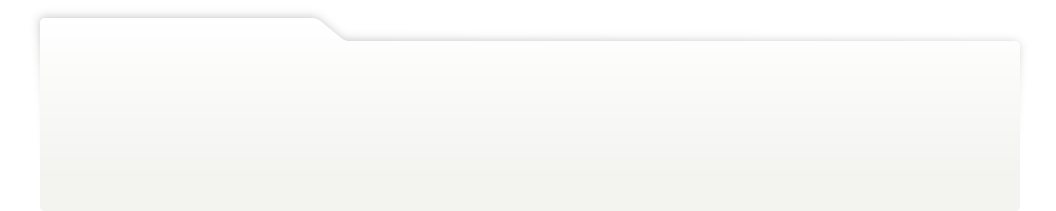
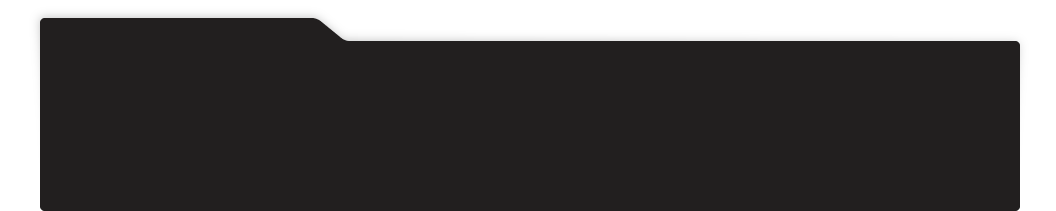
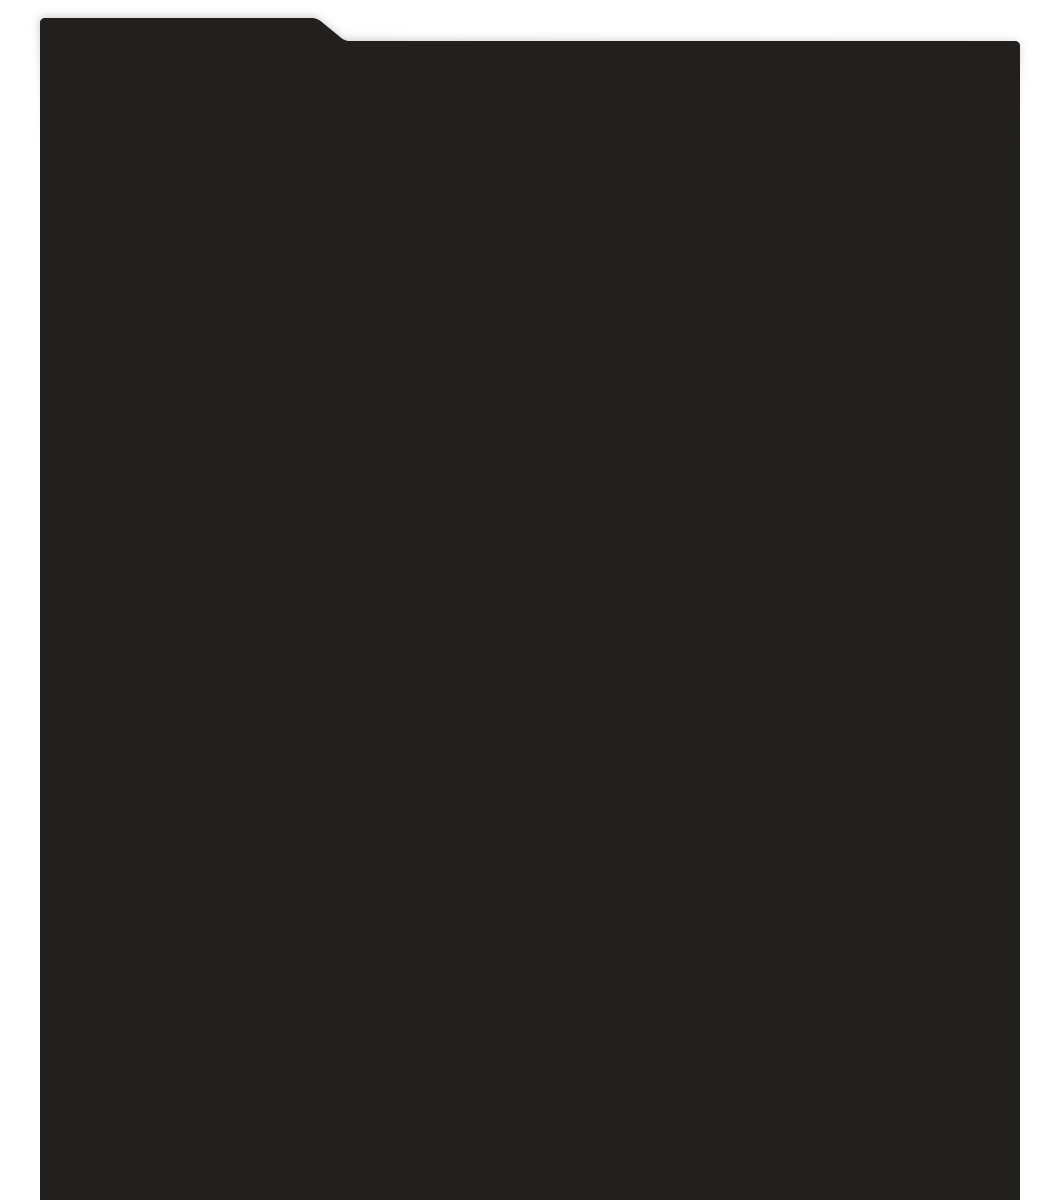
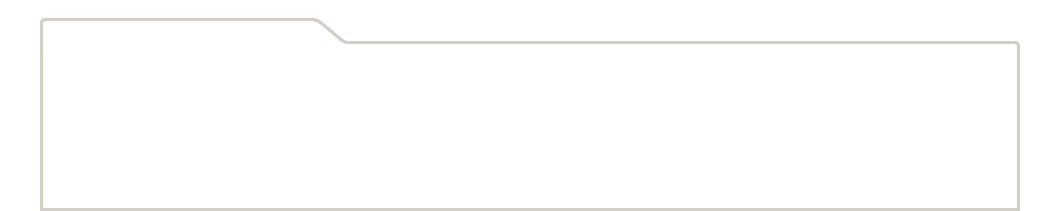
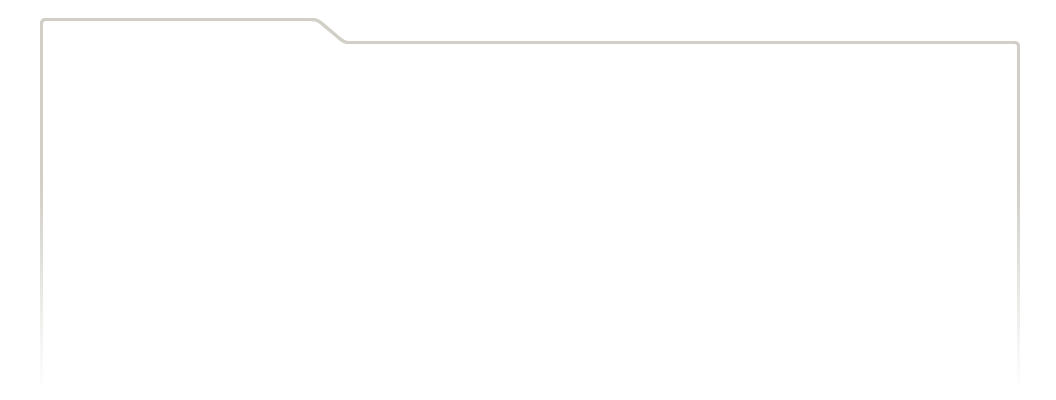
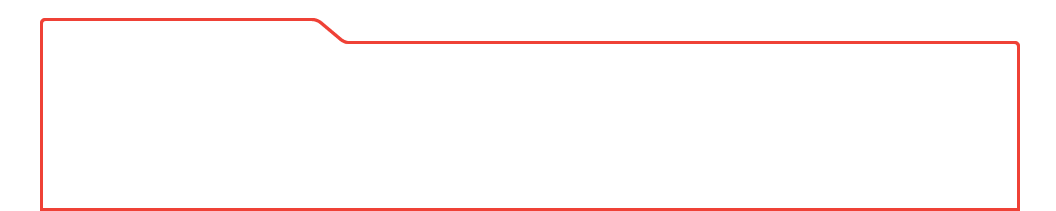
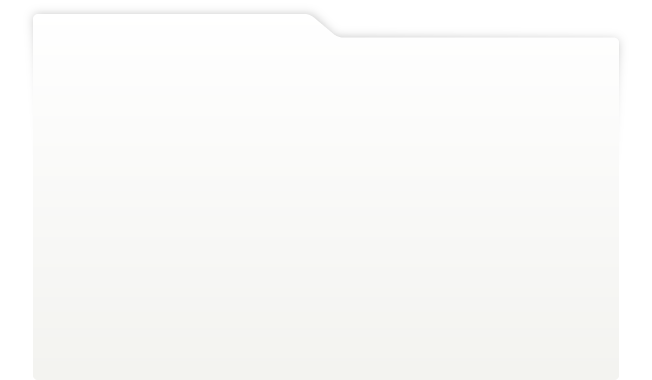
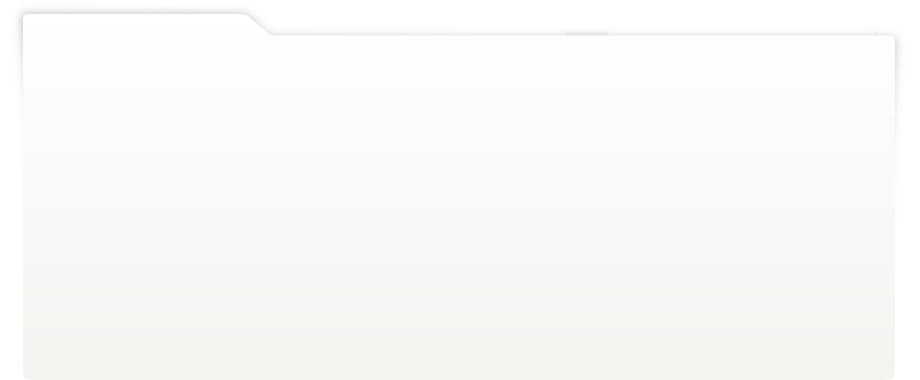
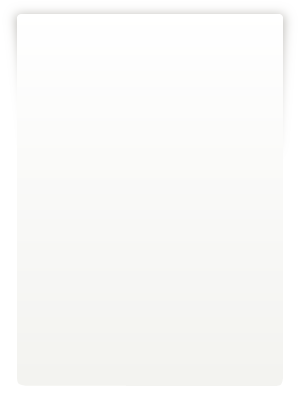
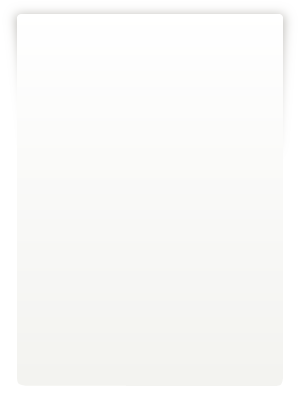
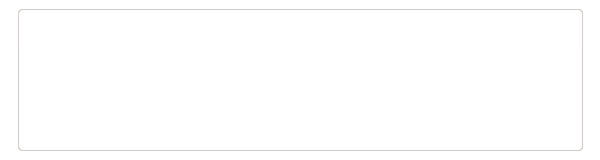
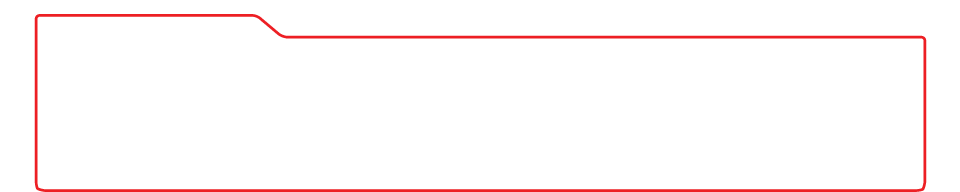
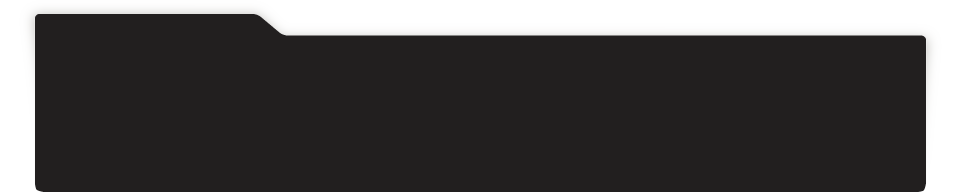
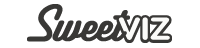
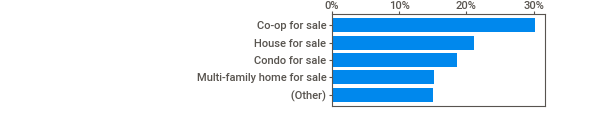
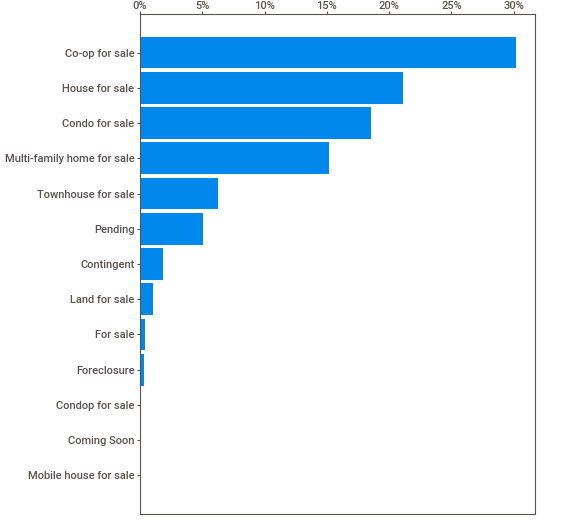
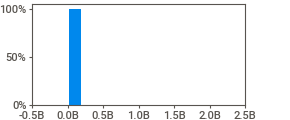
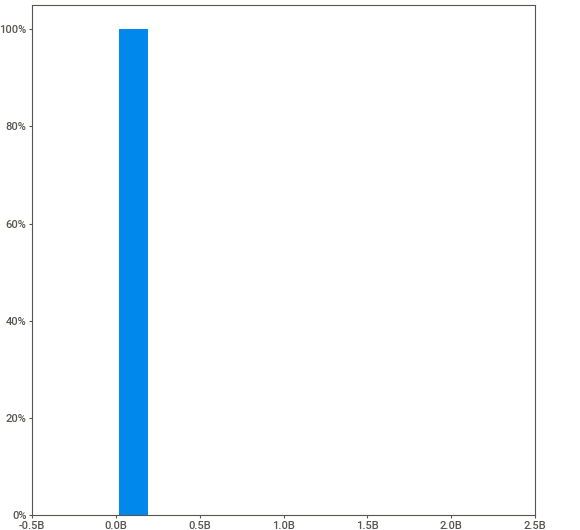
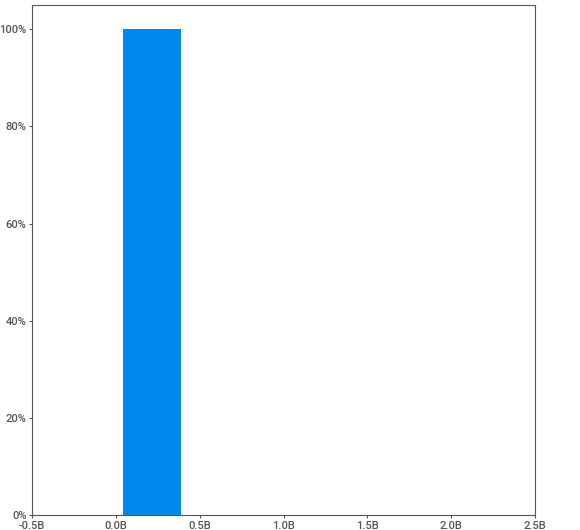
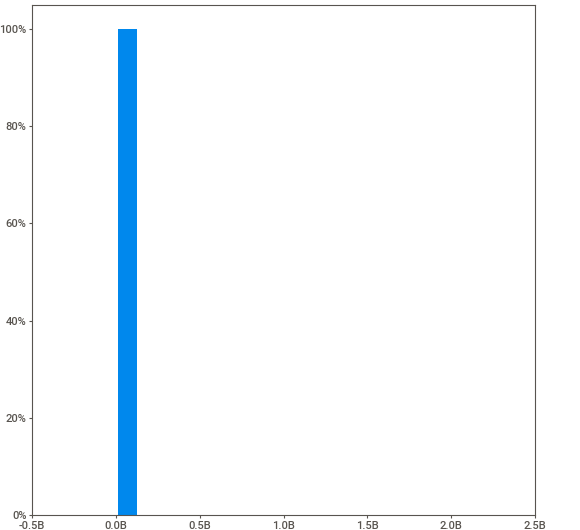
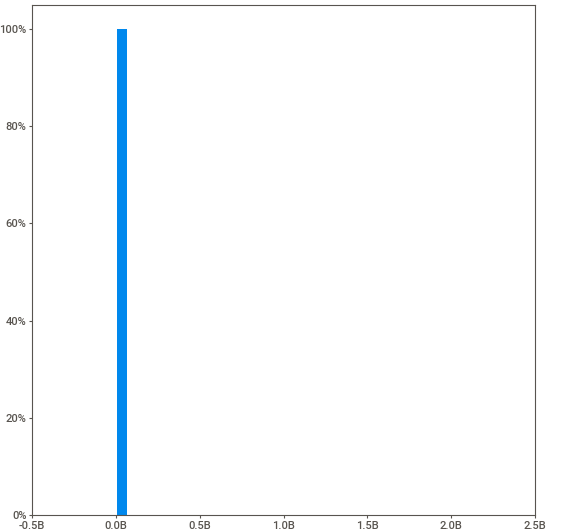
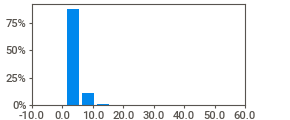
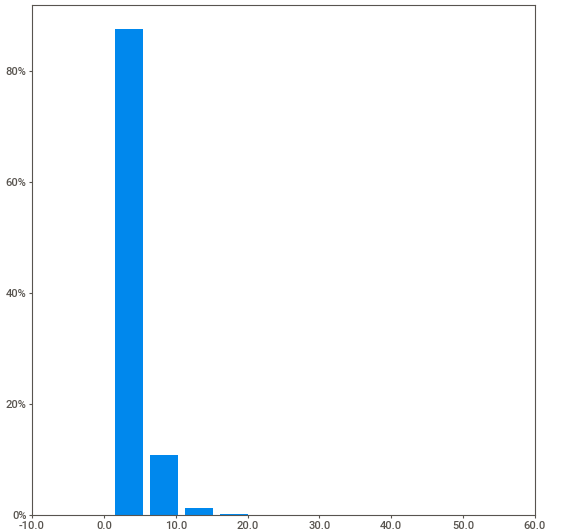
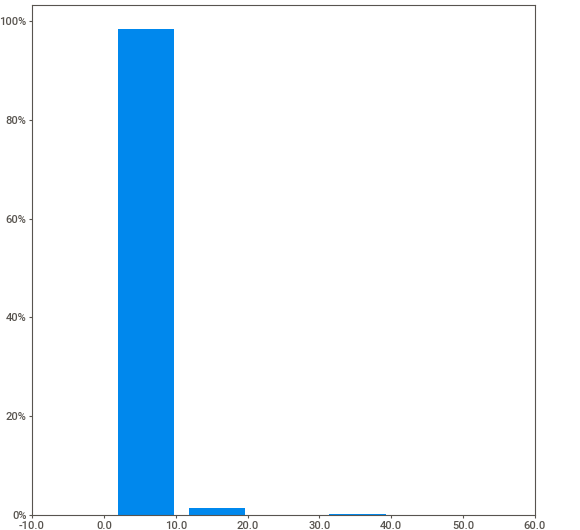
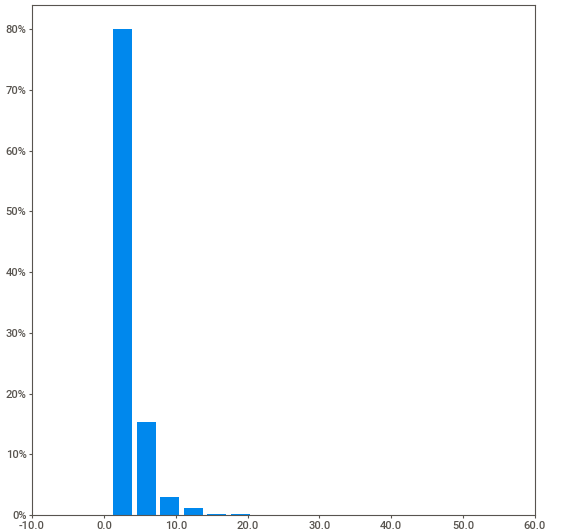
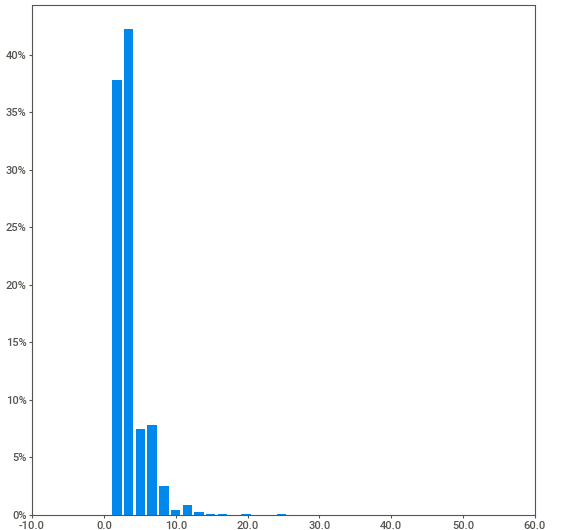
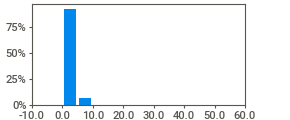
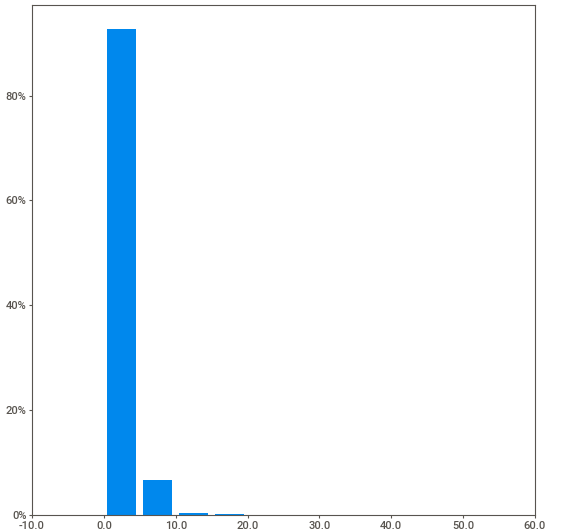
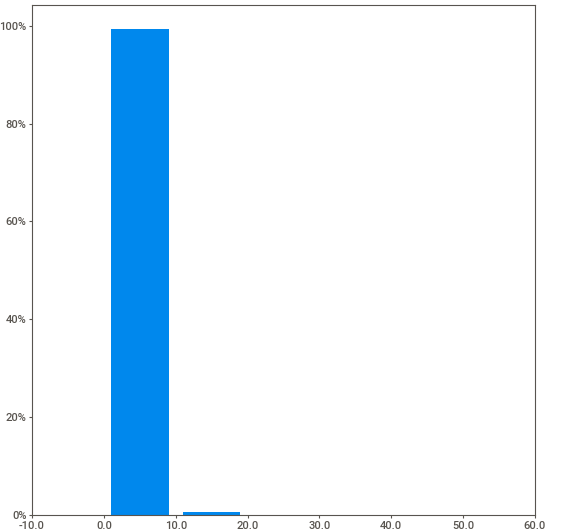
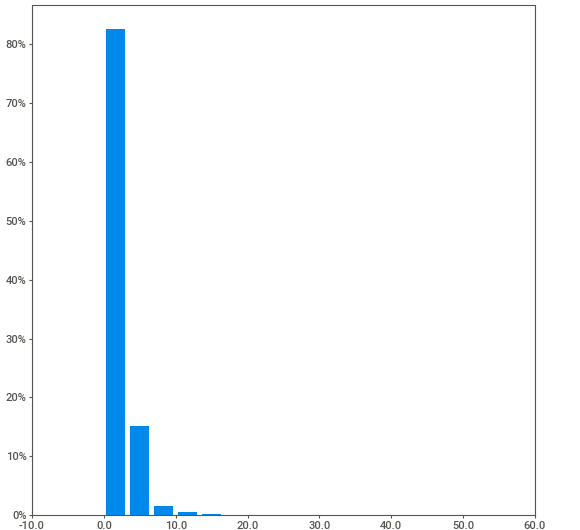
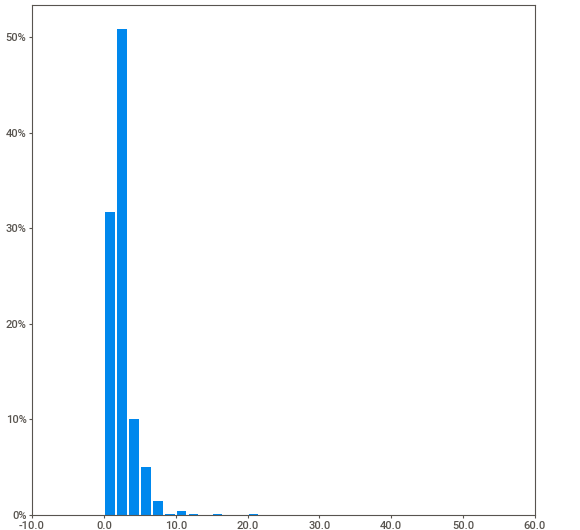
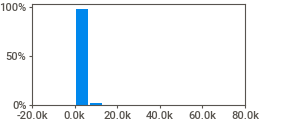
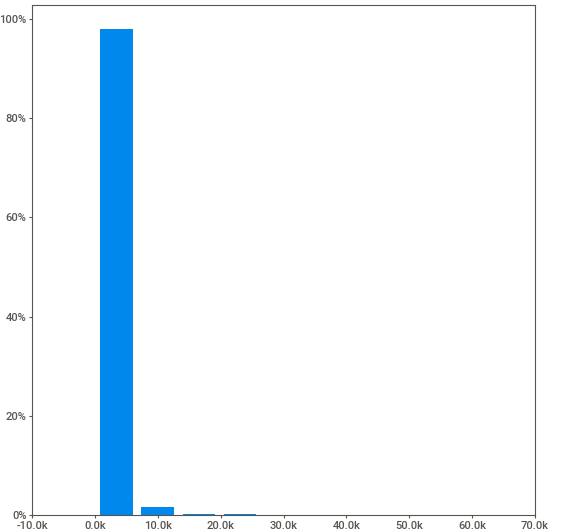
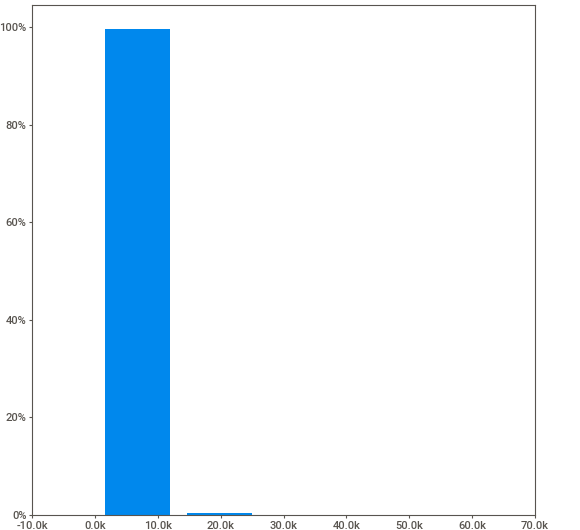
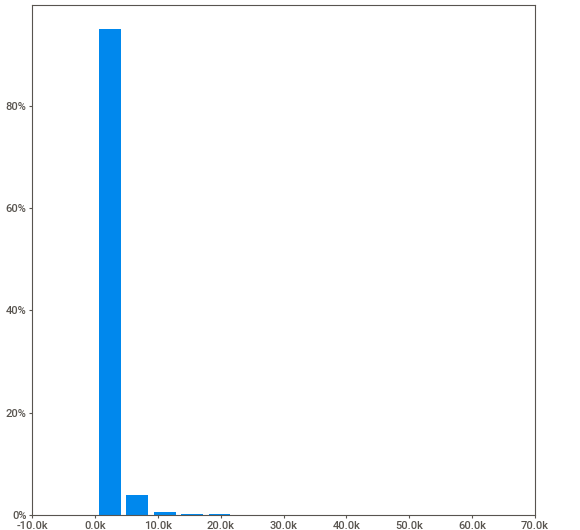
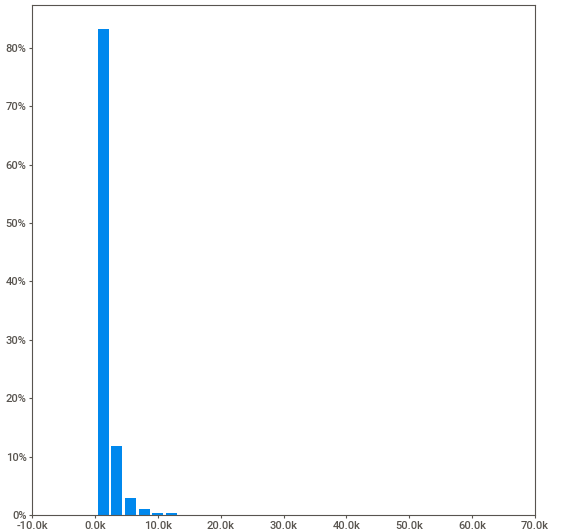
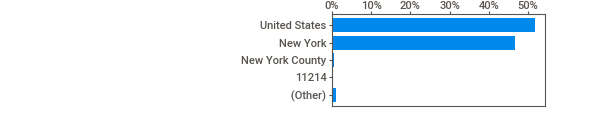
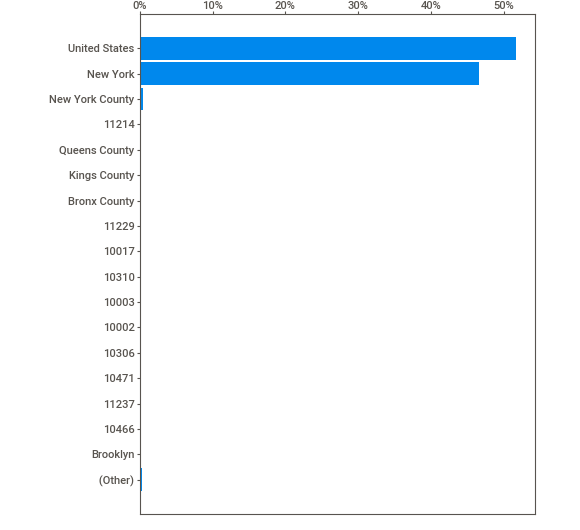
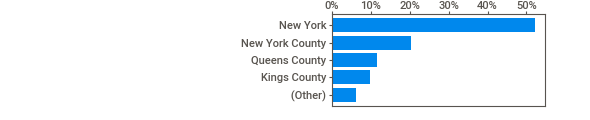
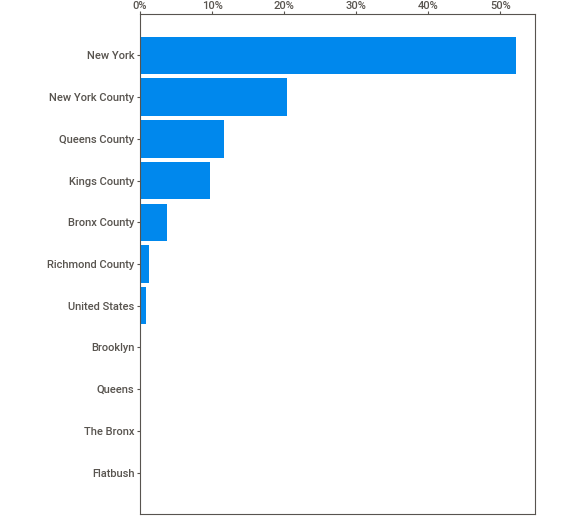
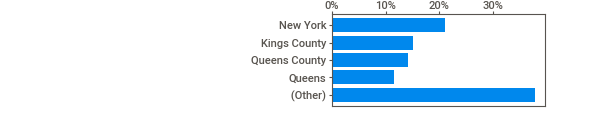
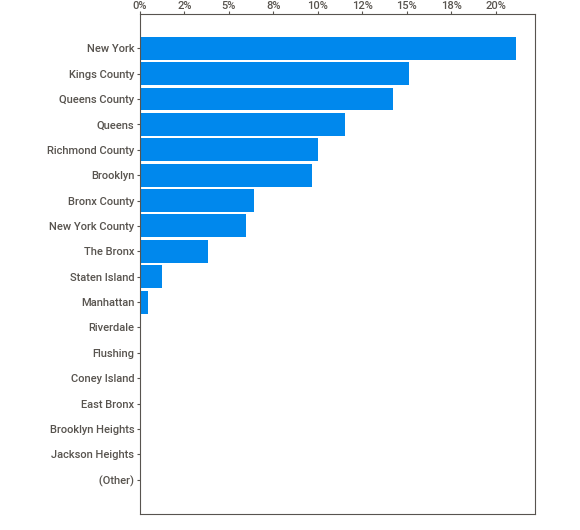
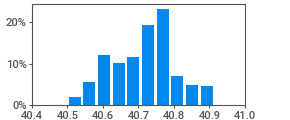
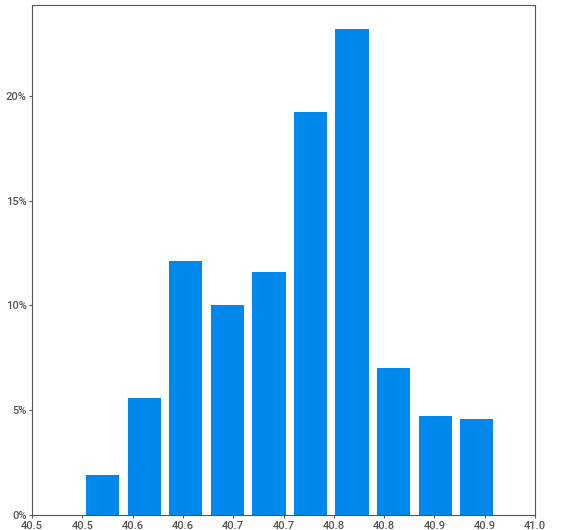
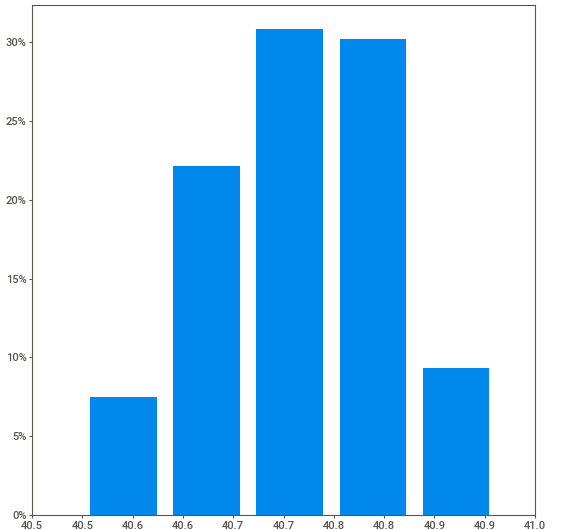
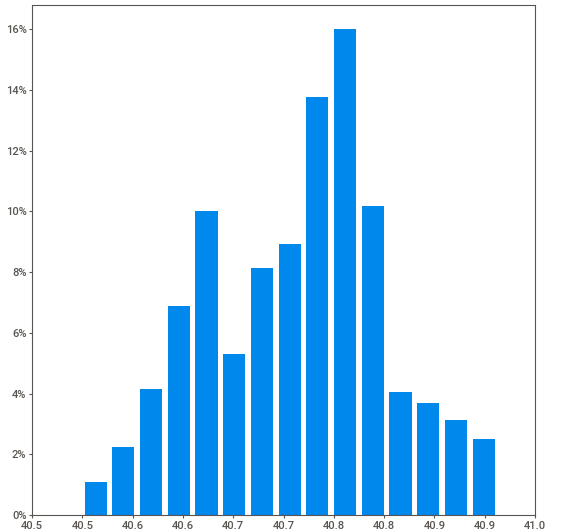
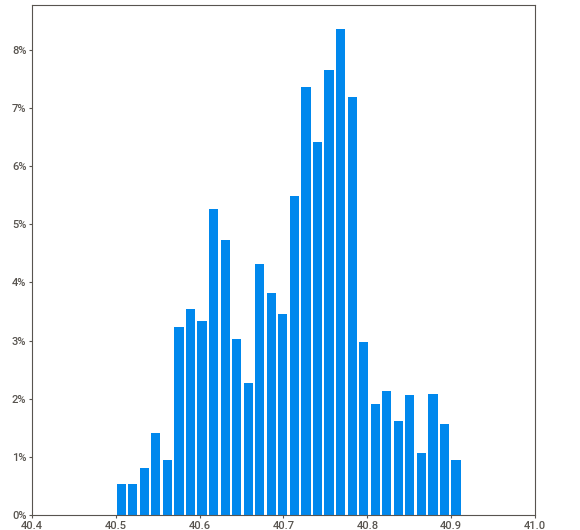
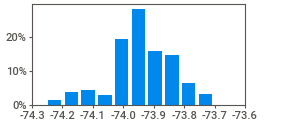
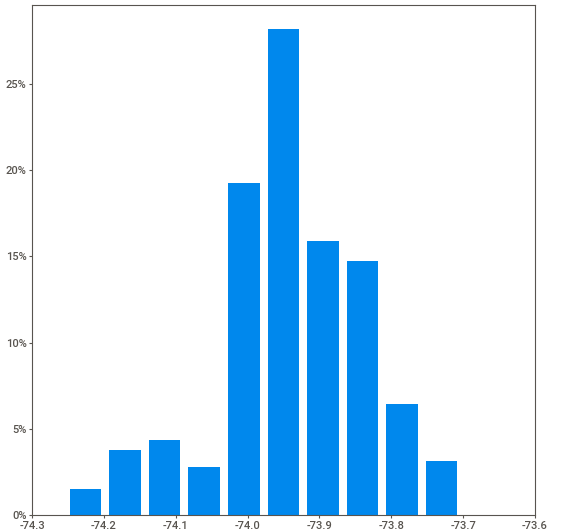
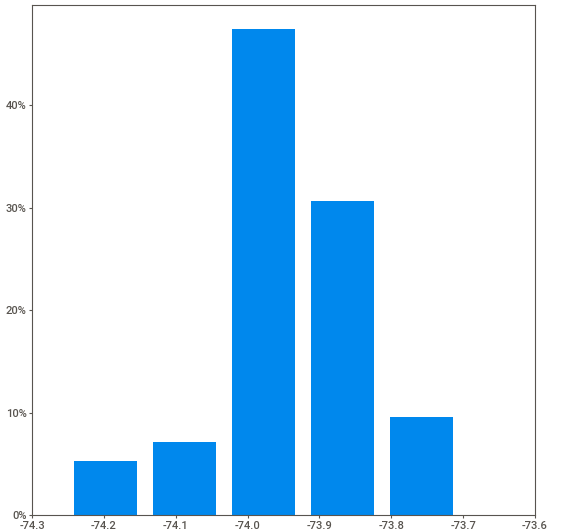
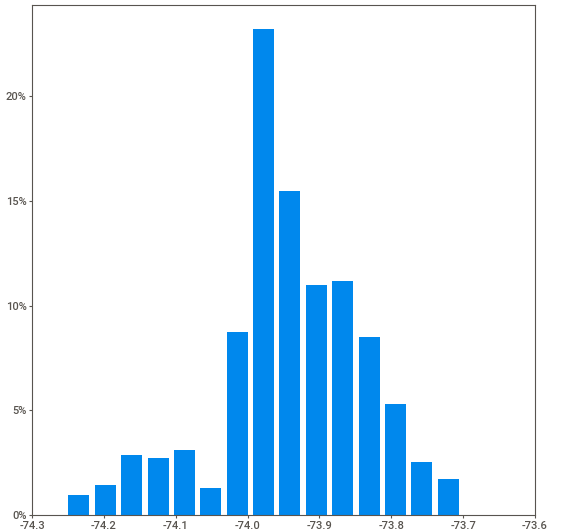
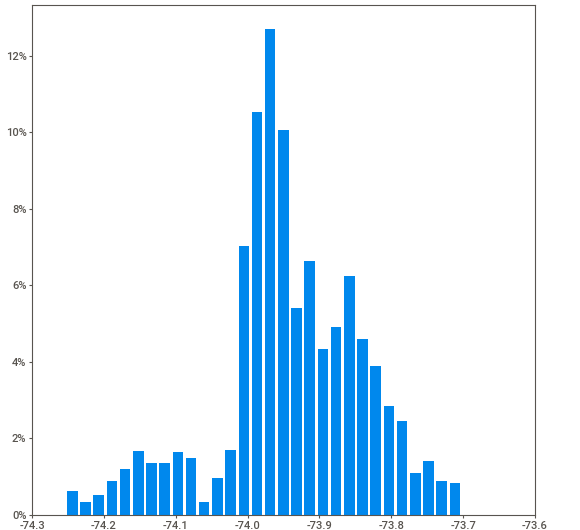
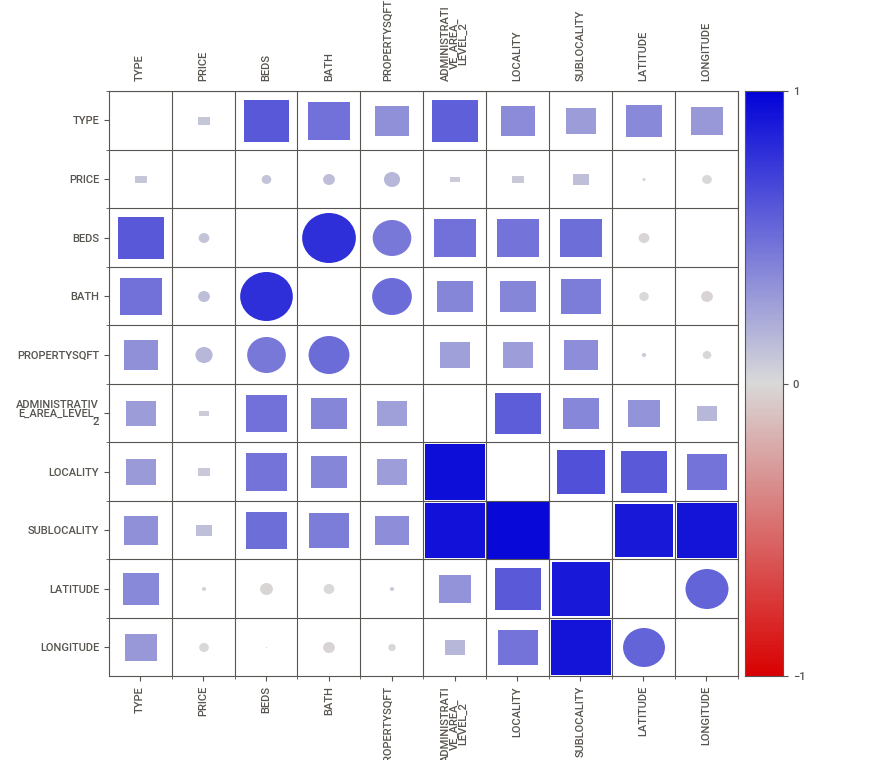
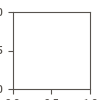

In [ ]:
my_report.show_notebook(w=None,
                h=None,
                scale=None,
                layout='widescreen',
                filepath=None)

In [ ]:
profile = ProfileReport(ny_house_data, title="Profiling Report")
profile.to_file("ny_house_report.html")

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:354: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Check for null values
ny_house_data.isnull().sum()

BROKERTITLE                    0
TYPE                           0
PRICE                          0
BEDS                           0
BATH                           0
PROPERTYSQFT                   0
ADDRESS                        0
STATE                          0
MAIN_ADDRESS                   0
ADMINISTRATIVE_AREA_LEVEL_2    0
LOCALITY                       0
SUBLOCALITY                    0
STREET_NAME                    0
LONG_NAME                      0
FORMATTED_ADDRESS              0
LATITUDE                       0
LONGITUDE                      0
dtype: int64

In [ ]:
# Check for duplicates
ny_house_data.duplicated().sum()

214

In [ ]:
# Remove duplicates
ny_house_data.drop_duplicates(inplace=True)

In [ ]:
# Check the shape of our data
ny_house_data.shape

(4587, 17)

In [ ]:
# Selecting only numerical columns
numerical_columns = ny_house_data.drop(['LATITUDE', 'LONGITUDE'], axis=1).select_dtypes(include=[np.number])

In [ ]:
# Calculating the Interquartile Range (IQR) for each numerical column
Q1 = numerical_columns.quantile(0.25)
Q3 = numerical_columns.quantile(0.75)
IQR = Q3 - Q1

# Defining the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Finding outliers by checking if values fall outside the bounds
outliers = (numerical_columns < lower_bound) | (numerical_columns > upper_bound)

# Printing outliers for each numerical column
for column in outliers.columns:
    print(f"Outliers in {column}:")
    print(ny_house_data[outliers[column]][column])
    print()

Outliers in PRICE:
1       195000000
4        55000000
7        16800000
46        4250000
54        3250000
          ...    
4733     21000000
4745     10500000
4765      3450000
4788      4750000
4795      2999999
Name: PRICE, Length: 528, dtype: int64

Outliers in BEDS:
7        8
27      12
29      10
32      10
36      11
        ..
4702     8
4721     9
4760     8
4786    12
4795    15
Name: BEDS, Length: 218, dtype: int64

Outliers in BATH:
1       10
7       16
32       8
99       8
119      8
        ..
4651     9
4691    17
4745    10
4792     7
4795     9
Name: BATH, Length: 108, dtype: int64

Outliers in PROPERTYSQFT:
1       17545.0
4       14175.0
5        4004.0
7       33000.0
27       5670.0
         ...   
4691    12733.0
4722     5427.0
4745     7040.0
4759     4100.0
4792     7854.0
Name: PROPERTYSQFT, Length: 374, dtype: float64



In [ ]:
# Calculating the number of outliers in each numerical column
num_outliers = outliers.sum()

# Computing the percentage of outliers in each numerical column
total_rows = ny_house_data.shape[0]
percentage_outliers = (num_outliers / total_rows) * 100

# Creating a DataFrame to store the results
outlier_stats = pd.DataFrame({
    'Num_Outliers': num_outliers,
    'Percentage_Outliers': percentage_outliers
})

# Displaying the outlier statistics
print("Outlier Statistics:")
outlier_stats

Outlier Statistics:


,Num_Outliers,Percentage_Outliers
PRICE,528,11.510791
BEDS,218,4.752562
BATH,108,2.354480
PROPERTYSQFT,374,8.153477


In [ ]:
# Selecting columns with outliers
outlier_columns = ['PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT']

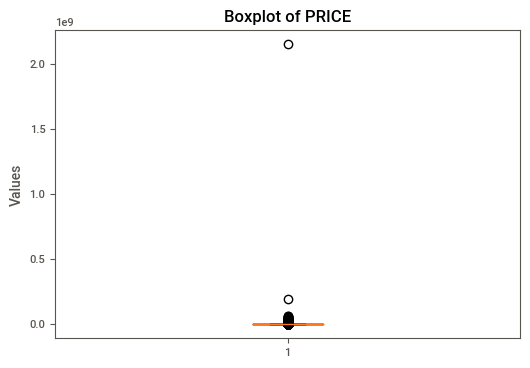

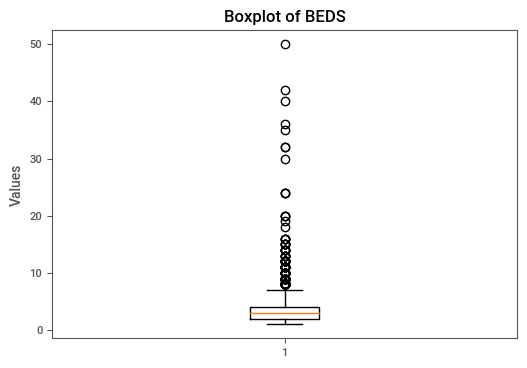

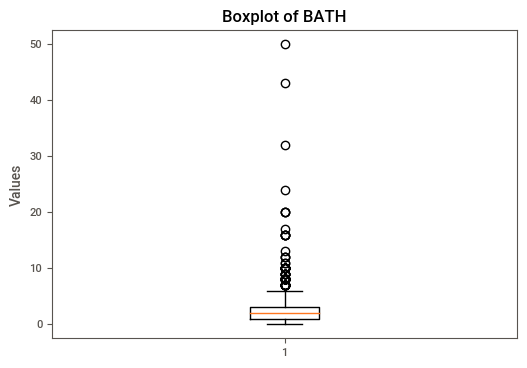

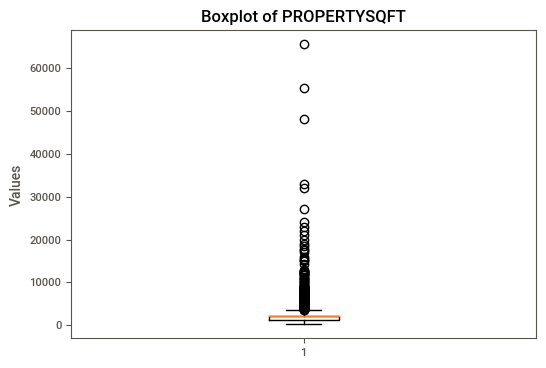

In [ ]:
# Plotting box plots for each column with outliers separately
for column in outlier_columns:
    plt.figure(figsize=(6, 4))
    plt.boxplot(ny_house_data[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')
    plt.show()

In [ ]:
# Calculate z-scores
z_scores = (ny_house_data['PRICE'] - ny_house_data['PRICE'].mean()) / ny_house_data['PRICE'].std()

# Threshold for identifying outliers
threshold = 3

# Identify outliers
outliers = ny_house_data[abs(z_scores) > threshold]
outliers

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
1,Brokered by Serhant,Condo for sale,195000000,7,10,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
304,Brokered by ANNE LOPA REAL ESTATE,House for sale,2147483647,7,6,10000.0,6659-6675 Amboy Rd,"New York, NY 10309","6659-6675 Amboy RdNew York, NY 10309",United States,New York,Richmond County,Staten Island,Amboy Road,"6659 Amboy Rd, Staten Island, NY 10309, USA",40.518484,-74.224418


Given that the outliers represent very luxurious houses, removing them may not be appropriate approach for now. Luxurious properties may indeed have significantly higher prices compared to the rest of the dataset, but they could still be valid and important data points.

In [ ]:
# Log-Transform the target variable to make it normal distribution
ny_house_data['PRICE_log'] = ny_house_data['PRICE'].apply(lambda x: np.log(x))

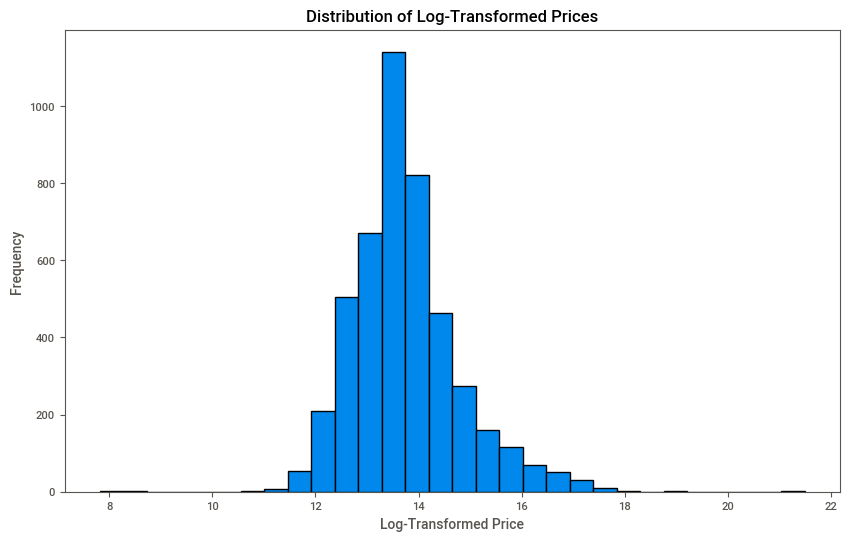

In [ ]:
# Plot histogram of log-transformed prices
plt.figure(figsize=(10, 6))
plt.hist(ny_house_data['PRICE_log'], bins=30, edgecolor='black')
plt.title('Distribution of Log-Transformed Prices')
plt.xlabel('Log-Transformed Price')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Check unique values of the TYPE column
ny_house_data['TYPE'].unique()

array(['Condo for sale', 'House for sale', 'Townhouse for sale',
       'Co-op for sale', 'Multi-family home for sale', 'For sale',
       'Contingent', 'Land for sale', 'Foreclosure', 'Pending',
       'Coming Soon', 'Mobile house for sale', 'Condop for sale'],
      dtype=object)

Explanation of the different types of properties commonly found in the New York real estate market:

- Condo for sale: Condominiums are individual units within a larger building or complex. Owners have title to their individual unit and share ownership of common areas with other unit owners.

- House for sale: This refers to standalone residential properties, typically detached from other structures, such as single-family homes or detached houses.

- Townhouse for sale: Townhouses, also known as row houses or terraced houses, are narrow, multi-story homes that share walls with adjacent properties. They are often arranged in rows and have a similar architectural style.

- Co-op for sale: Cooperative apartments, or co-ops, are multi-unit buildings where residents own shares in the corporation that owns the entire property. Instead of owning their individual unit, co-op owners hold shares that entitle them to occupy a specific unit.

- Multi-family home for sale: These are properties with multiple separate living units, such as duplexes, triplexes, or apartment buildings. Each unit typically has its own entrance and amenities.

- For sale: This category may encompass various types of properties that are listed for sale but may not fit into the other specific categories provided.

- Contingent: Properties listed as contingent are under contract with a buyer, but certain conditions must be met before the sale can be finalized. For example, the sale might be contingent on the buyer securing financing or completing a home inspection.

- Land for sale: Refers to vacant land or lots that are available for purchase. Buyers may purchase land for development, investment, or other purposes.

- Foreclosure: These properties are owned by a bank or lender as a result of the previous owner's failure to make mortgage payments. They are typically sold at auction or through a real estate agent.

- Pending: Properties that are pending are under contract and in the process of closing. The sale has not yet been completed, but all necessary steps are being taken to finalize the transaction.

- Coming Soon: Indicates that the property will be listed for sale in the near future but is not yet officially on the market.

- Mobile house for sale: Refers to mobile or manufactured homes, which are prefabricated dwellings that can be transported and placed on a permanent or semi-permanent foundation.

- Condop for sale: A condop is a hybrid between a condominium and a cooperative apartment. It typically operates as a co-op but has some features of a condo, such as individual unit ownership and more flexible subletting rules.

In [ ]:
# Check unique values of the ADMINISTRATIVE_AREA_LEVEL_2 column
ny_house_data['ADMINISTRATIVE_AREA_LEVEL_2'].unique()

array(['New York County', 'United States', 'New York', 'Bronx County',
       '11214', '10301', '10309', '10303', '11234', '11414', '10310',
       '10003', '11417', '10304', 'Kings County', '10463',
       'Queens County', '10017', '10306', '10471', '11229', '10312',
       '11412', '10465', 'Brooklyn', '10002', '10466', '11237', '11218'],
      dtype=object)

NYC contains 5 counties: **New York County, Bronx County, Kings County, Queens County, and Richmond County**. Each county makes up one of the boroughs; **Manhattan, the Bronx, Brooklyn, Queens, and Staten Island** respectively. We will try to fix the columns 'LOCALITY' and 'SUBLOCALITY' according to this hierarchy in order to have columns ready to encode and give the to the regression algorithms.

In [ ]:
# Check unique values of the LOCALITY column
ny_house_data['LOCALITY'].unique()

array(['New York', 'New York County', 'The Bronx', 'Kings County',
       'Bronx County', 'Queens County', 'Richmond County',
       'United States', 'Brooklyn', 'Queens', 'Flatbush'], dtype=object)

In [ ]:
# Replace 'United States' in LOCALITY column with values from STREET_NAME column
ny_house_data.loc[ny_house_data['LOCALITY'] == 'United States', 'LOCALITY'] = ny_house_data.loc[ny_house_data['LOCALITY'] == 'United States', 'STREET_NAME']

# Check unique values after correction
ny_house_data['LOCALITY'].unique()

array(['New York', 'New York County', 'The Bronx', 'Kings County',
       'Bronx County', 'Queens County', 'Richmond County', 'Brooklyn',
       'Queens', 'Flatbush'], dtype=object)

In [ ]:
# Define the mapping for locality correction
locality_mapping = {
    'New York': 'New York County',
    'The Bronx': 'Bronx County',
    'Queens': 'Queens County',
    'Brooklyn': 'Kings County',
    'Flatbush': 'Kings County'
}

# Apply the mapping to the LOCALITY column
ny_house_data['LOCALITY'] = ny_house_data['LOCALITY'].map(locality_mapping).fillna(ny_house_data['LOCALITY'])

# Check unique values after correction
ny_house_data['LOCALITY'].unique()

array(['New York County', 'Bronx County', 'Kings County', 'Queens County',
       'Richmond County'], dtype=object)

Now LOCALITY contains the 5 counties of the first level of the hierarchy of NY counties:
'New York County', 'Bronx County', 'Kings County', 'Queens County',    'Richmond County'

In [ ]:
ny_house_data['SUBLOCALITY'].unique()

array(['Manhattan', 'New York County', 'Richmond County', 'Kings County',
       'New York', 'East Bronx', 'Brooklyn', 'The Bronx', 'Queens',
       'Staten Island', 'Queens County', 'Bronx County', 'Coney Island',
       'Brooklyn Heights', 'Jackson Heights', 'Riverdale', 'Rego Park',
       'Fort Hamilton', 'Flushing', 'Dumbo', 'Snyder Avenue'],
      dtype=object)

Sublocality contains information about the boroughs of New York, but we find it more extensively informative in STATE column, where we will take the first part and replace it in SUBLOCALITY.

In [ ]:
# Check the unique values of STATE column
ny_house_data['STATE'].unique()

array(['New York, NY 10022', 'New York, NY 10019',
       'Staten Island, NY 10312', 'Manhattan, NY 10022',
       'New York, NY 10065', 'Brooklyn, NY 11238', 'New York, NY 10027',
       'Staten Island, NY 10304', 'Bronx, NY 10473', 'Brooklyn, NY 11230',
       'Bronx, NY 10451', 'Staten Island, NY 10303',
       'Jackson Heights, NY 11372', 'Elmhurst, NY 11373',
       'New York, NY 10014', 'Woodside, NY 11377', 'Brooklyn, NY 11209',
       'Bronx, NY 10471', 'Rego Park, NY 11374',
       'Staten Island, NY 10301', 'Forest Hills, NY 11375',
       'Bronx, NY 10465', 'Staten Island, NY 10307',
       'Briarwood, NY 11435', 'Queens, NY 11372', 'Brooklyn, NY 11214',
       'Staten Island, NY 10314', 'Brooklyn, NY 11207',
       'Brooklyn, NY 11219', 'Flushing, NY 11355', 'Brooklyn, NY 11249',
       'Bronx, NY 10453', 'Brooklyn, NY 11204', 'Woodhaven, NY 11421',
       'Jamaica, NY 11435', 'Manhattan, NY 10012', 'Flushing, NY 11358',
       'Richmond Hill South, NY 11419', 'New York, NY

In [ ]:
# Split the 'STATE' column to extract the first part
ny_house_data['SUBLOCALITY'] = ny_house_data['STATE'].apply(lambda x: x.split(',')[0].strip())

# Check unique values after correction
ny_house_data['SUBLOCALITY'].unique()

array(['New York', 'Staten Island', 'Manhattan', 'Brooklyn', 'Bronx',
       'Jackson Heights', 'Elmhurst', 'Woodside', 'Rego Park',
       'Forest Hills', 'Briarwood', 'Queens', 'Flushing', 'Woodhaven',
       'Jamaica', 'Richmond Hill South', 'Whitestone', 'Ridgewood',
       'Rosedale', 'Ozone Park', 'Springfield Gardens', 'Far Rockaway',
       'Bellerose', 'Bayside', 'Astoria', 'Floral Park', 'Fresh Meadows',
       'Howard Beach', 'Cambria Heights', 'Rockaway Park',
       'East Elmhurst', 'Little Neck', 'Long Island City', 'Ny', 'Corona',
       'Kew Gardens', 'Brownville', 'Brooklyn Heights', 'Maspeth',
       'Queens Village', 'Richmond Hill', 'Middle Village',
       'Saint Albans', 'Kensington', 'South Ozone Park', 'Canarsie',
       'College Point', 'Bedford Stuyvesant', 'New York City', 'Hollis',
       'Malba', 'Glen Oaks', 'Douglaston', 'Sunnyside', 'Arverne',
       'Glendale', 'New Hyde Park', 'Crown Heights', 'Old Mill Basin',
       'Beechhurst', 'Roosevelt Island', 

In [ ]:
# Replace variations of 'New York' with 'New York'
ny_house_data['SUBLOCALITY'] = ny_house_data['SUBLOCALITY'].replace(['Ny', 'New York City', 'Nyc'], 'New York')

# Replace variations of 'Bronx' with 'Bronx'
ny_house_data['SUBLOCALITY'] = ny_house_data['SUBLOCALITY'].replace(['Bronx Ny'], 'Bronx')

# Check unique values after replacement
ny_house_data['SUBLOCALITY'].unique()

array(['New York', 'Staten Island', 'Manhattan', 'Brooklyn', 'Bronx',
       'Jackson Heights', 'Elmhurst', 'Woodside', 'Rego Park',
       'Forest Hills', 'Briarwood', 'Queens', 'Flushing', 'Woodhaven',
       'Jamaica', 'Richmond Hill South', 'Whitestone', 'Ridgewood',
       'Rosedale', 'Ozone Park', 'Springfield Gardens', 'Far Rockaway',
       'Bellerose', 'Bayside', 'Astoria', 'Floral Park', 'Fresh Meadows',
       'Howard Beach', 'Cambria Heights', 'Rockaway Park',
       'East Elmhurst', 'Little Neck', 'Long Island City', 'Corona',
       'Kew Gardens', 'Brownville', 'Brooklyn Heights', 'Maspeth',
       'Queens Village', 'Richmond Hill', 'Middle Village',
       'Saint Albans', 'Kensington', 'South Ozone Park', 'Canarsie',
       'College Point', 'Bedford Stuyvesant', 'Hollis', 'Malba',
       'Glen Oaks', 'Douglaston', 'Sunnyside', 'Arverne', 'Glendale',
       'New Hyde Park', 'Crown Heights', 'Old Mill Basin', 'Beechhurst',
       'Roosevelt Island', 'Kew Gardens Hills', 'S

And by this we kept the information about the borough and their relevant neighborhood of each property. However, in our models we will use only SUBLOCALITY as independent variable.

In [ ]:
# Make a copy of ny_house_data and drop unnecessary columns
df_model = ny_house_data.drop(columns=['BROKERTITLE', 'ADDRESS', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2', 'STREET_NAME', 'LOCALITY', 'LONG_NAME', 'FORMATTED_ADDRESS', 'PRICE']).copy()

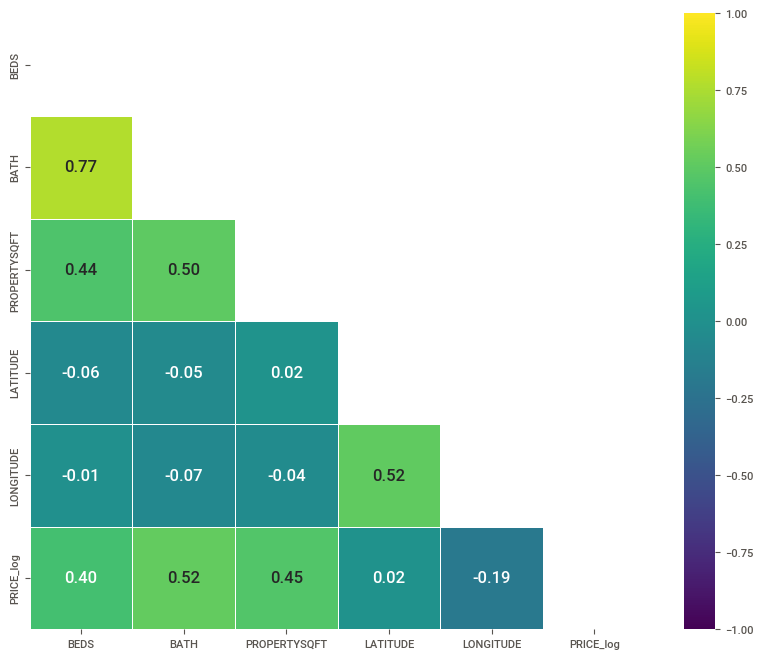

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df_model.corr()

# Create a mask using numpy's triu function
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a masked heatmap
plt.figure(figsize = (10,8))
plt.rcParams.update({'font.size': 12})
sns.heatmap(correlation_matrix, cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5, mask = mask)
plt.show()

In [ ]:
df_model.head()

,TYPE,BEDS,BATH,PROPERTYSQFT,SUBLOCALITY,LATITUDE,LONGITUDE,PRICE_log
0,Condo for sale,2,2,1400.0,New York,40.761255,-73.974483,12.660328
1,Condo for sale,7,10,17545.0,New York,40.766393,-73.980991,19.088510
2,House for sale,4,2,2015.0,Staten Island,40.541805,-74.196109,12.468437
3,Condo for sale,3,1,445.0,Manhattan,40.761398,-73.974613,11.141862
4,Townhouse for sale,7,2,14175.0,New York,40.767224,-73.969856,17.822844


## Encoding

In [ ]:
# Define the features to encode
features_to_encode = ['TYPE', 'SUBLOCALITY']

# Perform one-hot encoding
encoded_data = pd.get_dummies(df_model, columns=features_to_encode)

# Save the column names of the encoded features
encoded_columns = encoded_data.columns.tolist()

# Save the column names to a file (you can use pickle or any other serialization method)
with open('encoded_columns.pkl', 'wb') as f:
    pickle.dump(encoded_columns, f)

## Standard Scaling

In [ ]:
# Define features to scale
features_to_scale = encoded_data.columns

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(encoded_data)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=features_to_scale)
scaled_df.head()

,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE,PRICE_log,TYPE_Co-op for sale,TYPE_Coming Soon,TYPE_Condo for sale,TYPE_Condop for sale,...,SUBLOCALITY_Rosedale,SUBLOCALITY_Saint Albans,SUBLOCALITY_South Ozone Park,SUBLOCALITY_Springfield Gardens,SUBLOCALITY_Staten Island,SUBLOCALITY_Stuyvesant Heights,SUBLOCALITY_Sunnyside,SUBLOCALITY_Whitestone,SUBLOCALITY_Woodhaven,SUBLOCALITY_Woodside
0,-0.519614,-0.179790,-0.340677,0.539423,-0.324881,-1.051378,-0.6587,-0.020886,2.108967,-0.029543,...,-0.039095,-0.060991,-0.067817,-0.051215,-0.359122,-0.020886,-0.025582,-0.086415,-0.05533,-0.087687
1,1.382596,3.880253,6.731634,0.597996,-0.389143,5.180482,-0.6587,-0.020886,2.108967,-0.029543,...,-0.039095,-0.060991,-0.067817,-0.051215,-0.359122,-0.020886,-0.025582,-0.086415,-0.05533,-0.087687
2,0.241270,-0.179790,-0.071276,-1.962052,-2.513448,-1.237408,-0.6587,-0.020886,-0.474166,-0.029543,...,-0.039095,-0.060991,-0.067817,-0.051215,2.784568,-0.020886,-0.025582,-0.086415,-0.05533,-0.087687
3,-0.139172,-0.687295,-0.759014,0.541052,-0.326159,-2.523468,-0.6587,-0.020886,2.108967,-0.029543,...,-0.039095,-0.060991,-0.067817,-0.051215,-0.359122,-0.020886,-0.025582,-0.086415,-0.05533,-0.087687
4,1.382596,-0.179790,5.255407,0.607457,-0.279186,3.953470,-0.6587,-0.020886,-0.474166,-0.029543,...,-0.039095,-0.060991,-0.067817,-0.051215,-0.359122,-0.020886,-0.025582,-0.086415,-0.05533,-0.087687


In [ ]:
# Save the scaler to a file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## Modeling

In [ ]:
# Assigning features (X) and target variable (y) for machine learning model
X = scaled_df.drop(columns = 'PRICE_log')
y = scaled_df['PRICE_log']

In [ ]:
# # Splitting the dataset into training and testing sets for both features (X) and target variable (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Create XGBRegressor instance
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Create RandomForestRegressor instance
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Create GradientBoostingRegressor instance
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

# Evaluation
models = {'XGBRegressor': xgb_pred,
          'RandomForestRegressor': rf_pred,
          'GradientBoostingRegressor': gb_pred}

for name, pred in models.items():
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f'Model: {name}')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R^2 Score: {r2}')
    print('-----------------------------')

Model: XGBRegressor
Mean Squared Error: 0.18781584544239188
Mean Absolute Error: 0.2835315321860049
R^2 Score: 0.8065293747872923
-----------------------------
Model: RandomForestRegressor
Mean Squared Error: 0.18698848856721273
Mean Absolute Error: 0.28101565751314594
R^2 Score: 0.807381641812675
-----------------------------
Model: GradientBoostingRegressor
Mean Squared Error: 0.1967256416716017
Mean Absolute Error: 0.295396747549944
R^2 Score: 0.7973513214504039
-----------------------------


## Hyperparameter Tuning

In [ ]:
# XGBRegressor hyperparameter tuning
xgb_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb_grid_search = GridSearchCV(estimator=XGBRegressor(), param_grid=xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train, y_train)

# RandomForestRegressor hyperparameter tuning
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)

# GradientBoostingRegressor hyperparameter tuning
gb_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

gb_grid_search = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=gb_param_grid, cv=5)
gb_grid_search.fit(X_train, y_train)

# Best parameters for each model
print("XGBRegressor Best Parameters:", xgb_grid_search.best_params_)
print("RandomForestRegressor Best Parameters:", rf_grid_search.best_params_)
print("GradientBoostingRegressor Best Parameters:", gb_grid_search.best_params_)

XGBRegressor Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
RandomForestRegressor Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
GradientBoostingRegressor Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


## Retraining models

In [ ]:
# Retraining XGBRegressor with best parameters
xgb_model_tuned = XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 500)
xgb_model_tuned.fit(X_train, y_train)
xgb_pred_tuned = xgb_model_tuned.predict(X_test)

# Retraining RandomForestRegressor with best parameters
rf_model_tuned = RandomForestRegressor(max_depth=None, min_samples_split=2, n_estimators=500)
rf_model_tuned.fit(X_train, y_train)
rf_pred_tuned = rf_model_tuned.predict(X_test)

# Retraining GradientBoostingRegressor with best parameters
gb_model_tuned = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 300)
gb_model_tuned.fit(X_train, y_train)
gb_pred_tuned = gb_model_tuned.predict(X_test)

# Evaluation
models_tuned = {'XGBRegressor': xgb_pred_tuned,
                'RandomForestRegressor': rf_pred_tuned,
                'GradientBoostingRegressor': gb_pred_tuned}

for name, pred in models_tuned.items():
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f'Model: {name}')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R^2 Score: {r2}')
    print('-----------------------------')

Model: XGBRegressor
Mean Squared Error: 0.18241120569137717
Mean Absolute Error: 0.2787322899468741
R^2 Score: 0.8120967380159662
-----------------------------
Model: RandomForestRegressor
Mean Squared Error: 0.18422673783377033
Mean Absolute Error: 0.27868330822873466
R^2 Score: 0.81022654363564
-----------------------------
Model: GradientBoostingRegressor
Mean Squared Error: 0.17837727588341837
Mean Absolute Error: 0.2785492445502309
R^2 Score: 0.816252121818497
-----------------------------


Based on our metrics, it appears that the GradientBoostingRegressor model has slightly better performance compared to the XGBRegressor and RandomForestRegressor models.

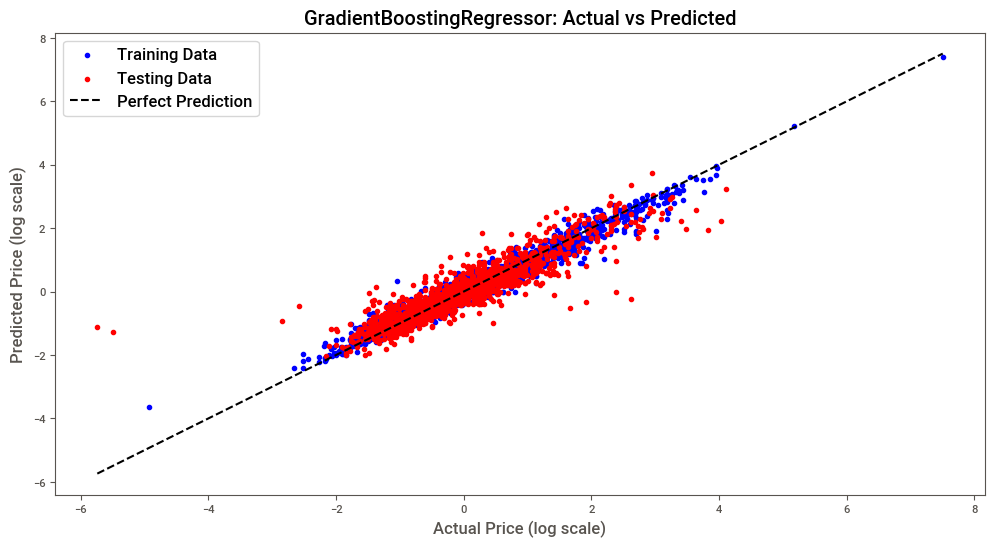

In [ ]:
# Predictions on training data
train_predictions = gb_model_tuned.predict(X_train)

# Predictions on testing data
test_predictions = gb_model_tuned.predict(X_test)

# Plotting the training data
plt.figure(figsize=(12, 6))
plt.scatter(y_train, train_predictions, color='blue', label='Training Data')

# Plotting the testing data
plt.scatter(y_test, test_predictions, color='red', label='Testing Data')

# Plotting the line y = x for reference
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
         color='black', linestyle='--', label='Perfect Prediction')

plt.title('GradientBoostingRegressor: Actual vs Predicted')
plt.xlabel('Actual Price (log scale)')
plt.ylabel('Predicted Price (log scale)')
plt.legend()
plt.show()

In [ ]:
# Save the trained model using pickle
with open('gradient_boosting_model.pkl', 'wb') as model_file:
    pickle.dump(gb_model_tuned, model_file)

## Deployment

In [ ]:
from flask import Flask, render_template, request
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler

app = Flask(__name__)

# Set the static folder path
app.config['STATIC_FOLDER'] = 'static'

# Load the scaler
with open('scaler.pkl', 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)

# Load the model
with open('gradient_boosting_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

# Define the prediction route
@app.route('/', methods=['GET', 'POST'])
def predict():
    if request.method == 'POST':
        # Get the form data
        property_type = request.form['property_type']
        neighborhood = request.form['neighborhood']
        property_sqft = float(request.form['property_sqft'])
        bedrooms = int(request.form['bedrooms'])
        baths = int(request.form['baths'])

        # Load the column names of the encoded features
        with open('encoded_columns.pkl', 'rb') as f:
          encoded_columns = pickle.load(f)

        # Perform one-hot encoding for categorical variables
        type_encoded = pd.get_dummies(pd.Series(property_type)).reindex(columns=encoded_columns, fill_value=0)
        sublocality_encoded = pd.get_dummies(pd.Series(neighborhood)).reindex(columns=encoded_columns, fill_value=0)

        # Concatenate encoded features
        encoded_features = pd.concat([type_encoded, sublocality_encoded], axis=1)

        # Scale the entire feature vector (both numerical and encoded categorical features)
        input_features = np.array([[property_sqft, bedrooms, baths]])  # Numerical features
        input_features_scaled = scaler.transform(np.concatenate([input_features, encoded_features.values], axis=1))

        # Make the prediction
        prediction = model.predict(input_features_scaled)
        output = round(prediction[0], 2)

        # Display the prediction result
        return render_template('index.html', prediction_text='House price should be ${} '.format(output))

    return render_template('index.html')

if __name__ == '__main__':
    app.run(port=5000, debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
